In [187]:
'''
IMPORTS
'''

%matplotlib inline

# Standard imports
import copy
import itertools

# Scientific computing imports
import numpy
import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd
from collections import Counter

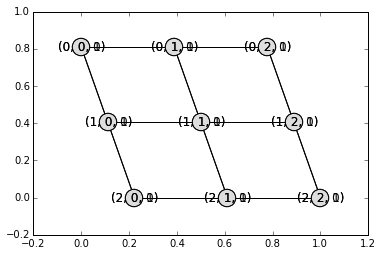

In [216]:
#zone grid
grid_size=[3,3,2]
g=nx.grid_graph(dim=grid_size)
g_layout = nx.spectral_layout(g)
nx.draw_networkx(g, pos=g_layout, node_color='#dddddd')

#label streets and penetrations
streets={}
geometric_characteristics={'H':'horizontal','L':'longitudinal','T':'transverse'}
structural_denotation=['T','L','H']
transfer_types={'E':None,'M':None,'I':None,'H':None}
for i in range(len(grid_size)):
    for structure in range(grid_size[i]+1):
        s_name='{}{}'.format(structural_denotation[i],structure)
        streets[s_name]={}
        streets[s_name]['orientation']=geometric_characteristics[structural_denotation[i]]
        streets[s_name]['availability']=list(transfer_types)

#link structure and edges between zones (vertices)
#print streets
for u,v in g.edges():
    coord_change=[(a is b) for a, b in zip(u,v)].index(False)
    if coord_change==0: #move in x
        g[u][v]['penetration']='T{}'.format(max(u[0],v[0]))
        g[u][v]['streets']=['L{}'.format(u[1]),'L{}'.format((u[1]+1)),'H{}'.format(u[2]),'H{}'.format((u[2]+1))]   
    
    if coord_change==1: #move in y
        g[u][v]['penetration']='L{}'.format(max(u[1],v[1]))
        g[u][v]['streets']=['H{}'.format(u[1]),'H{}'.format((u[1]+1)),'T{}'.format(u[2]),'T{}'.format((u[2]+1))]
        
    if coord_change==2: #move in z
        g[u][v]['penetration']='H{}'.format(max(u[2],v[2]))
        g[u][v]['streets']=['T{}'.format(u[1]),'T{}'.format((u[1]+1)),'L{}'.format(u[2]),'L{}'.format((u[2]+1))]        

    
#generate default information dual
i_g=nx.Graph()
for key in streets:
    if streets[key]['orientation'] is 'horizontal':
        for cross_street in streets:
            if streets[cross_street]['orientation'] is not 'horizontal':
                i_g.add_edge(key,cross_street)
                
    if streets[key]['orientation'] is 'transverse':
        for cross_street in streets:
            if streets[cross_street]['orientation'] is not 'transverse':
                i_g.add_edge(key,cross_street)
                
    if streets[key]['orientation'] is 'longitudinal':
        for cross_street in streets:
            if streets[cross_street]['orientation'] is not 'longitudinal':
                i_g.add_edge(key,cross_street)
                


In [111]:
#create affordance network
aff_g=nx.Graph()

#try with two
aff_g.add_edge('A1','A2',transfer='E',paths=[])
aff_g.add_edge('A2','A3',transfer='M',paths=[])
aff_g.node['A1']['loc']=[]
aff_g.node['A2']['loc']=[]
aff_g.node['A3']['loc']=[]



In [217]:
#create affordance network
aff_g=nx.Graph()

#try with two
aff_g.add_edge('A1','A2',transfer='E',paths=[])
aff_g.add_edge('A2','A3',transfer='M',paths=[])
aff_g.node['A1']['loc']=[]
aff_g.node['A2']['loc']=[]
aff_g.node['A3']['loc']=[]
aff_g.node['A1']['loc_possible']=[(0,0,0)]
aff_g.node['A2']['loc_possible']=[]
#aff_g.node['A2']['loc_possible']=[(0,1,0),(1,1,0),(0,1,1)]
aff_g.node['A3']['loc_possible']=[(1,1,1)]

#routing development

#first get the available subgraph
for transfer in transfer_types:
    s_g=nx.Graph()
    for j,k,d in g.edges(data=True):
        available_streets=[]
        for street in d['streets']:
            if transfer in streets[street]['availability']:
                available_streets.append(street)
        if available_streets:
            s_g.add_edge(j,k,streets=available_streets)
    transfer_types[transfer]=s_g

#create dataframe for results
e_incidence=pd.DataFrame(index=g.edges(),columns=aff_g.edges())
e_incidence=e_incidence.fillna(0)
#print e_incidence

n_incidence=pd.DataFrame(index=g.nodes(),columns=aff_g.nodes())
n_incidence=n_incidence.fillna(0)
#print n_incidence

a_incidence=pd.DataFrame(index=aff_g.nodes(),columns=aff_g.nodes())
a_incidence=a_incidence.fillna(0)
#print a_incidence

ae_incidence=pd.DataFrame(index=aff_g.edges(),columns=aff_g.edges())
ae_incidence=ae_incidence.fillna(0)
#print ae_incidence

arrangements=1
while arrangements<100:
    arrangements+=1
    for n,n_d in aff_g.nodes(data=True):
        if n_d['loc_possible']:
            n_loc=n_d['loc_possible'][numpy.random.randint(len(n_d['loc_possible']))]
        else:
            n_loc=g.nodes()[numpy.random.randint(len(g.nodes()))]
        aff_g.node[n]['loc'].append(n_loc)
        n_incidence.ix[n_loc,n]+=1
    
    #post-process locations
    for n1,n1_d in aff_g.nodes(data=True): #get affordance incidence
        for n2,n2_d in aff_g.nodes(data=True):
            if n1==n2:
                continue
            if n1_d['loc'][-1]==n2_d['loc'][-1]:
                a_incidence.ix[n1,n2]+=1
                #a_incidence.ix[n2,n1]+=1

    walks=[]
    for u,v,d in aff_g.edges(data=True):
        base_graph=transfer_types[d['transfer']]
        #random walk from start to finish
        walk=nx.Graph()
        walk.add_node(aff_g.node[u]['loc'][-1])
        last_added=aff_g.node[u]['loc'][-1]
        while aff_g.node[v]['loc'][-1] not in walk.nodes():
            adding_node=g.neighbors(last_added)[numpy.random.randint(len(base_graph.neighbors(last_added)))]
            walk.add_edge(last_added,adding_node)
            last_added=adding_node

        walks.append(walk)

        aff_g[u][v]['paths'].append(walk.edges())
        for e in walk.edges():
            #print e, e in e_incidence.index
            if e in e_incidence.index:
                e_incidence.ix[e,(u,v)] += 1
            else:
                e_incidence.ix[e[::-1],(u,v)] += 1
            #print e_incidence
            
    #post-process edges
    for e1_u,e1_v in aff_g.edges():
        #print aff_g[e1_u][e1_v]
        path1=aff_g[e1_u][e1_v]['paths'][-1]
        for e2_u,e2_v in aff_g.edges():
            if (e1_u,e1_v)==(e2_u,e2_v):
                continue
            #print aff_g[e2_u][e2_v]['paths']
            path2=aff_g[e2_u][e2_v]['paths'][-1]
            for path_edge in path1:
                if (path_edge in path2) or (path_edge[::-1] in path2):
                    ae_incidence.ix[(e1_u,e1_v),(e2_u,e2_v)]+=1 #increment for each shared edge if no continue
                    break #only increment once
                        
            
        
    
        
        

print n_incidence
print e_incidence
print a_incidence
print ae_incidence
        
        

KeyError: 'H3'

In [160]:
print walks
print a_incidence


[<networkx.classes.graph.Graph object at 0x0000000014C8A358>, <networkx.classes.graph.Graph object at 0x0000000003EA2EB8>]
    A1  A3  A2
A1   0   0   0
A3   0   0   0
A2   0   0   0


In [31]:
a=[]
if a:
    print 'yes'
else:
    print 'no'

no


In [63]:
print numpy.random.randint(len([(0,0),(1,2)]))


1


In [50]:
l=1
n=l
n=2
print l
print n

1
2


In [121]:
e=(1,2)
print e
print e[::-1]

(1, 2)
(2, 1)


In [173]:
list1=[1,2,3]
list2=[1,2,3]
if not list(set(list1).intersection(list2)):
    print 'y'
cmp(list1,list2)

0

In [188]:
l1=[((0,0,0),(0,1,0)),((0,1,0),(1,1,0))]
l2=[((1,1,0),(0,1,0)),((0,0,0),(0,1,0))]

print sorted(l1) == sorted(l2)
print Counter(l1) == Counter(l2)

False
False


In [191]:
t=((0,0),(1,1))
print t
print t[::-1]

((0, 0), (1, 1))
((1, 1), (0, 0))


In [196]:
l=[]
print l[-1]

IndexError: list index out of range